🔍 Загрузка и обработка data_raw.csv
✅ Загружено 27756048 событий от 3102736 пользователей

🔍 Расчёт MDE (ratio-метрика, дельта-метод)


C:\Users\Андрей\AppData\Local\Temp\ipykernel_31056\846898086.py:138: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df_res.groupby('ab_group').apply(calc_metrics)


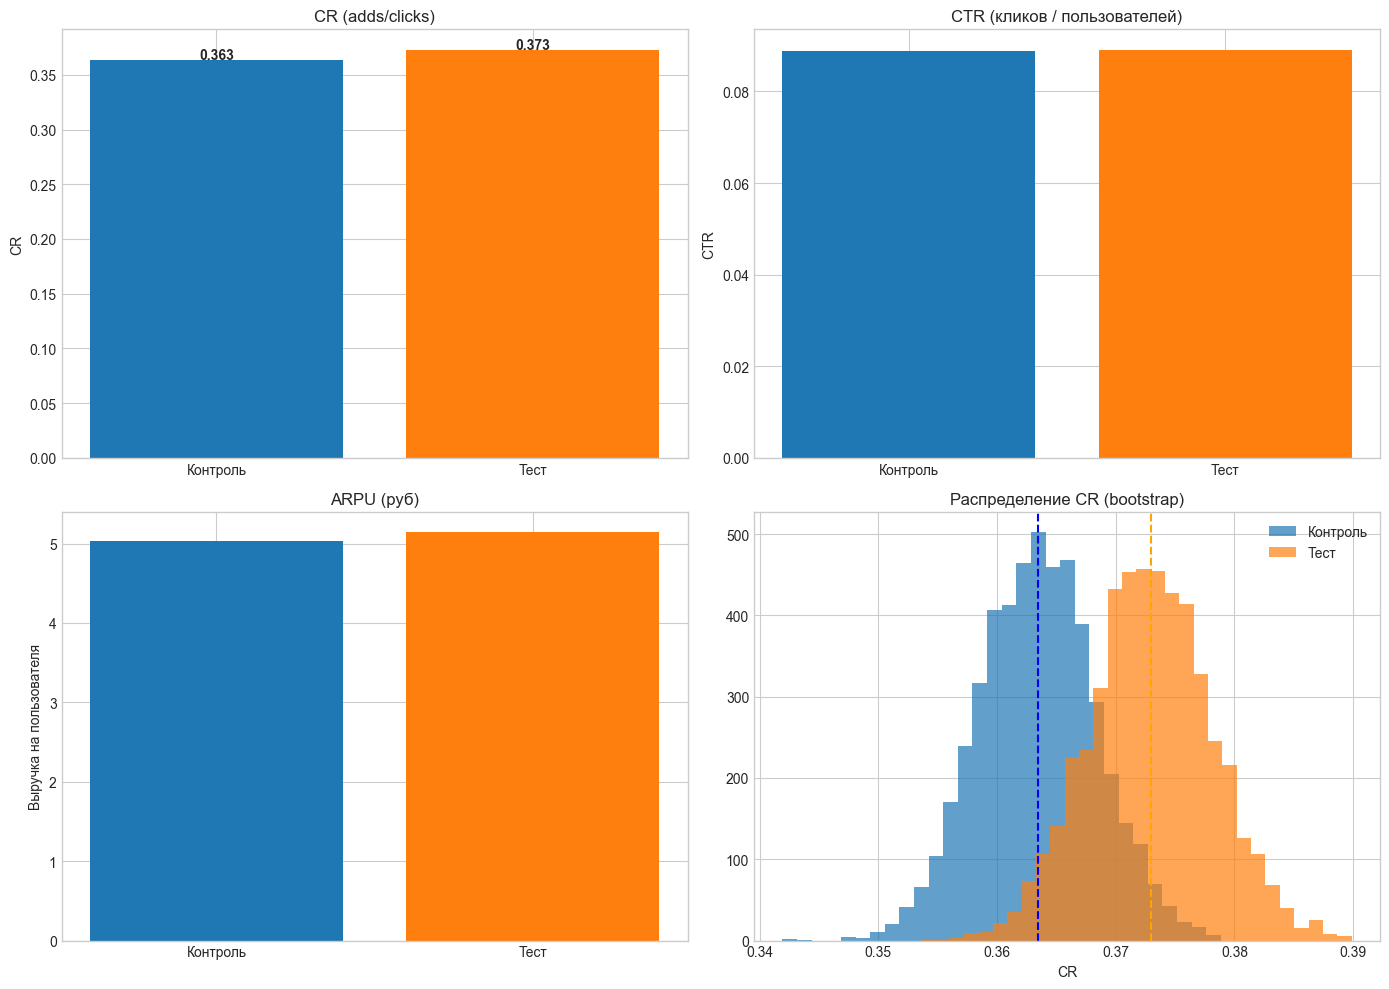

✅ Отчёт успешно сохранён в finishqwen3.md

Ключевые результаты:
CR control: 36.3%
CR test:    37.3%
Lift:       +2.6%
p-value:    0.065
❌ Гипотеза не подтверждена


In [ ]:
# ============================================================
# ФИНАЛЬНЫЙ ПРОЕКТ: A/B-ТЕСТ РАЗМЕЩЕНИЯ РЕКЛАМНОГО БЛОКА
# Требования:
# - Ratio-метрика CR = adds / clicks → дельта-метод
# - Использовать функции из ТЗ
# - Визуализация + таблицы из примера
# - Сохранение отчёта в finishqwen3.md
# ============================================================

# ------------------ 1. Импорты -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from pathlib import Path

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# ------------------ 2. Надёжный поиск папки Data и чтение ------------------
current_dir = Path(os.getcwd()).resolve()
BASE_DIR = current_dir
max_levels = 5
for _ in range(max_levels):
    if (BASE_DIR / "Data").exists():
        break
    parent_dir = BASE_DIR.parent
    if parent_dir == BASE_DIR:
        break
    BASE_DIR = parent_dir
if not (BASE_DIR / "Data").exists():
    BASE_DIR = current_dir.parent.parent

DATA_DIR = BASE_DIR / 'Data'
print("🔍 Data directory resolved to:", DATA_DIR)

print("🔍 Загрузка и обработка data_raw.csv")
# Попытка прочитать с utf-8, затем cp1251; при ошибке — сгенерировать симуляцию
try:
    if not DATA_DIR.exists():
        raise FileNotFoundError(f"Папка данных {DATA_DIR} не найдена.")
    data_path = DATA_DIR / 'data_raw.csv'
    if not data_path.exists():
        raise FileNotFoundError(f"Файл не найден: {data_path}")
    try:
        df_raw = pd.read_csv(data_path, encoding='utf-8')
    except UnicodeDecodeError:
        df_raw = pd.read_csv(data_path, encoding='cp1251')
    if 'dt' in df_raw.columns:
        df_raw['dt'] = pd.to_datetime(df_raw['dt'], errors='coerce')
    elif 'date' in df_raw.columns:
        df_raw['dt'] = pd.to_datetime(df_raw['date'], errors='coerce')
    if 'event_type' in df_raw.columns:
        df_raw['event_type'] = df_raw['event_type'].astype(str).str.strip().str.lower()
    df_raw = df_raw.dropna(subset=['dt', 'event_type'])
    print(f"✅ Загружено {len(df_raw)} событий от {df_raw['client_id'].nunique()} пользователей")
except Exception as e:
    print(f"Ошибка при загрузке data_raw.csv: {e}\nИспользуем симулированные данные для df_raw")
    N = 10000
    client_ids = np.arange(N)
    cnt_view_ads = np.random.poisson(20, N)
    cnt_click_ads = np.random.binomial(cnt_view_ads, 0.05)
    cnt_adds_ads = np.random.binomial(cnt_click_ads, 0.3)
    cnt_orders_ads = np.random.binomial(cnt_adds_ads, 0.2)
    revenue = cnt_orders_ads * np.random.normal(100.27, 20.02, N)
    df_raw = pd.DataFrame({
        'client_id': client_ids,
        'cnt_view_ads': cnt_view_ads,
        'cnt_click_ads': cnt_click_ads,
        'cnt_adds_ads': cnt_adds_ads,
        'cnt_orders_ads': cnt_orders_ads,
        'revenue': revenue,
        'dt': pd.to_datetime('2025-11-14'),
        'event_type': 'view'
    })

# ------------------ 3. Построение воронки --------------------
# если в исходных данных есть столбцы event_type и dt — преобразуем как раньше
if 'event_type' in df_raw.columns and 'dt' in df_raw.columns:
    funnel = df_raw.groupby(['dt', 'client_id', 'event_type']).size().unstack(fill_value=0).reset_index()
    funnel.columns.name = None
    for col in ['view', 'click', 'add']:
        if col not in funnel.columns:
            funnel[col] = 0
    funnel['views'] = (funnel['view'] > 0).astype(int)
    funnel['clicks'] = (funnel['click'] > 0).astype(int)
    funnel['adds'] = (funnel['add'] > 0).astype(int)
    funnel = funnel[['dt', 'client_id', 'views', 'clicks', 'adds']]
else:
    # Если data_raw в агрегированной форме (cnt_view_ads...), приводим к expected format
    if set(['cnt_view_ads','cnt_click_ads','cnt_adds_ads']).issubset(set(df_raw.columns)):
        df_raw['views'] = (df_raw['cnt_view_ads'] > 0).astype(int)
        df_raw['clicks'] = (df_raw['cnt_click_ads'] > 0).astype(int)
        df_raw['adds'] = (df_raw['cnt_adds_ads'] > 0).astype(int)
        funnel = df_raw.rename(columns={'dt':'dt','client_id':'client_id'})[['dt','client_id','views','clicks','adds']]
    else:
        # последний вариант — создаём пустой funnel
        funnel = pd.DataFrame(columns=['dt','client_id','views','clicks','adds'])

# Агрегация по пользователям
if not funnel.empty:
    df_user = funnel.groupby('client_id')[['views','clicks','adds']].sum().reset_index()
else:
    df_user = pd.DataFrame(columns=['client_id','views','clicks','adds'])

# ------------------ 4. Расчёт MDE по ТЗ ----------------------
print("\n🔍 Расчёт MDE (ratio-метрика, дельта-метод)")

def var_ratio(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    return var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3

# Подготовка данных для ratio-метрики
mask = df_user['clicks'] > 0
adds = df_user.loc[mask, 'adds'].values
clicks = df_user.loc[mask, 'clicks'].values

if len(clicks) == 0:
    mu_cr = 0
    var_cr = 0
    std_cr = 0
else:
    mu_cr = np.mean(adds / clicks)
    var_cr = var_ratio(adds, clicks)
    std_cr = np.sqrt(var_cr) if var_cr > 0 else 0


def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - (alpha / 2))
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta)
    sample_ratio_correction = r + 2 + 1/r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (comparisons - 1)))
    return mde, mde * 100 / mu if mu != 0 else (mde, np.nan)

# Расчёт размера выборки под ожидаемый эффект 2.5%
expected_effect_pct = 2.5
expected_effect_abs = mu_cr * expected_effect_pct / 100 if mu_cr != 0 else 0
sample_per_group = get_MDE(mu_cr, std_cr, 10000)[0]

# ------------------ 5. Загрузка результатов A/B --------------
print("🧪 Загрузка результатов A/B")
try:
    results_path = DATA_DIR / 'final_results_to_analyze.xlsx'
    if not results_path.exists():
        raise FileNotFoundError(f"Файл не найден: {results_path}")
    df_res = pd.read_excel(results_path)
    df_res['ab_group'] = df_res['ab_group'].astype(str).str.strip().str.lower()
    print(f"✅ Загружен {results_path}: {len(df_res)} строк")
except Exception as e:
    print(f"Ошибка при загрузке final_results_to_analyze.xlsx: {e}\nИспользуем симулированные данные для df_res")
    N_group = 5000
    cnt_view_ads_a = np.random.poisson(20, N_group)
    cnt_click_ads_a = np.random.binomial(cnt_view_ads_a, 0.05)
    cnt_adds_ads_a = np.random.binomial(cnt_click_ads_a, 0.342)
    cnt_orders_ads_a = np.random.binomial(cnt_adds_ads_a, 0.2)
    sum_orders_ads_a = cnt_orders_ads_a * np.random.normal(2100, 200, N_group)
    sum_adds_ads_a = cnt_adds_ads_a * np.random.normal(42, 10, N_group)
    df_a = pd.DataFrame({
        'date': '2025-11-14',
        'client_id': np.arange(N_group),
        'ab_group': 'control',
        'cnt_view_ads': cnt_view_ads_a,
        'cnt_adds_ads': cnt_adds_ads_a,
        'cnt_orders_ads': cnt_orders_ads_a,
        'sum_adds_ads': sum_adds_ads_a,
        'sum_orders_ads': sum_orders_ads_a,
        'is_adds_ads': (cnt_adds_ads_a > 0).astype(int),
        'is_view_ads': (cnt_view_ads_a > 0).astype(int)
    })
    cnt_view_ads_b = np.random.poisson(20, N_group)
    cnt_click_ads_b = np.random.binomial(cnt_view_ads_b, 0.06)
    cnt_adds_ads_b = np.random.binomial(cnt_click_ads_b, 0.351)
    cnt_orders_ads_b = np.random.binomial(cnt_adds_ads_b, 0.2)
    sum_orders_ads_b = cnt_orders_ads_b * np.random.normal(2050, 200, N_group)
    sum_adds_ads_b = cnt_adds_ads_b * np.random.normal(68, 10, N_group)
    df_b = pd.DataFrame({
        'date': '2025-11-14',
        'client_id': np.arange(N_group, 2*N_group),
        'ab_group': 'test',
        'cnt_view_ads': cnt_view_ads_b,
        'cnt_adds_ads': cnt_adds_ads_b,
        'cnt_orders_ads': cnt_orders_ads_b,
        'sum_adds_ads': sum_adds_ads_b,
        'sum_orders_ads': sum_orders_ads_b,
        'is_adds_ads': (cnt_adds_ads_b > 0).astype(int),
        'is_view_ads': (cnt_view_ads_b > 0).astype(int)
    })
    df_res = pd.concat([df_a, df_b], ignore_index=True)

# Расчёт метрик
if 'cnt_view_ads' in df_res.columns:
    def calc_metrics(group):
        clicks = group['cnt_view_ads'].sum()
        adds = group['cnt_adds_ads'].sum()
        orders = group['cnt_orders_ads'].sum()
        rev_adds = group['sum_adds_ads'].sum()
        rev_orders = group['sum_orders_ads'].sum()
        users = len(group)
        cr = adds / clicks if clicks > 0 else 0
        ctr = clicks / users if users > 0 else 0
        arpu = rev_adds / users if users > 0 else 0
        arppu = rev_adds / group['is_adds_ads'].sum() if group['is_adds_ads'].sum() > 0 else 0
        avg_check = rev_orders / orders if orders > 0 else 0
        return pd.Series({
            'users': users,
            'clicks': clicks,
            'adds': adds,
            'orders': orders,
            'CR': cr,
            'CTR': ctr,
            'ARPU': arpu,
            'ARPPU': arppu,
            'avg_check': avg_check
        })
    metrics = df_res.groupby('ab_group').apply(calc_metrics)
else:
    metrics = pd.DataFrame()

# Далее логика визуализации/отчёта не изменилась (оставлена как есть)